In [1]:
from PIL import Image
from rl_benchmarks.models import iBOTViT, iBOTSwin
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator
import pathlib
from tqdm import tqdm
from PIL import Image
import numpy as np
Image.MAX_IMAGE_PIXELS = None
from torchvision import transforms
import torch
from torch.utils.data import Dataset
import os
from multiprocessing import Pool
import umap
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from rl_benchmarks.utils.linear_evaluation import get_binary_class_metrics, get_bootstrapped_metrics, dict_to_dataframe
import umap.plot

/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [10]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = 'cpu'
# weights_path = '/home/yuxin/Downloads/ibot_vit_base_pancan.pth'
# weights_path = '/home/yuxin/Downloads/checkpoint0040.pth'
weights_path = '/home/yuxin/Downloads/swin_ckpt.pth'
# ibot_base_pancancer = iBOTViT(architecture="vit_base_pancan", encoder="teacher", weights_path=weights_path).to(device)
ibot_base_pancancer =iBOTSwin(architecture="swin_base", encoder="teacher", weights_path=weights_path).to(device)

2024-02-01 15:13:26.733 | INFO     | rl_benchmarks.models.feature_extractors.ibot_vit:__init__:181 - Pretrained weights found at /home/yuxin/Downloads/swin_ckpt.pth and loaded with msg: _IncompatibleKeys(missing_keys=['masked_embed', 'head.weight', 'head.bias'], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v', 'head.last_layer2.weight_g', 'head.last_layer2.weight_v'])


In [11]:
patch_size = 224
data_root = pathlib.Path('/mnt/hd0/ssd/SUQH_10x336')
# model_root = pathlib.Path('/home/yuxin/ssd_data/SUQH_10x_tiles/model_balanced')
test_root = pathlib.Path('/home/yuxin/ssd_data/SUQH_10x336/test')
phases = ['train', 'val', 'test']
# save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/pretrain_ssl_SUQH_10x336_tiles_model_balanced_features')
save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/finetune_ibot_swin')
save_root.mkdir(exist_ok=True)
data_trans = transforms.Compose([
                                # transforms.CenterCrop(336),
                                transforms.Resize(patch_size),
                                ibot_base_pancancer.transform,
                                ])

In [5]:
def get_type_grade(path):
    type_grade = path.parent.name
    if type_grade == 'normal':
        return 0,0
    elif type_grade == 'tis-1':
        return 1,0
    elif type_grade == 'tis-2':
        return 1,1
    elif type_grade == 'tis-3':
        return 1,2
    elif type_grade == 'it-1':
        return 2,0
    elif type_grade == 'it-2':
        return 2,1
    elif type_grade == 'it-3':
        return 2,2

In [12]:
X = {
    'train': [],
    'val': [],
    'test': []
}
Y = {
    'train': [],
    'val': [],
    'test': []
}
for phase in phases:
    phase_root = data_root / phase
    # if phase == 'model':
    #     tile_paths = list(phase_root.glob('**/*.png'))
    # else:
    tile_paths = list(phase_root.glob('**/*.jpg'))
    for path in tqdm(tile_paths, desc=f'Processing {phase}'):
        save_path = save_root / phase / path.parent.name /f'{path.stem}.npy' 
        if save_path.exists():
            feature = np.load(save_path)
        else:
            save_path.parent.mkdir(exist_ok=True, parents=True)
            im = Image.open(path)
            tensor = data_trans(im)
            batch = tensor.unsqueeze(0)
            batch = batch.to(device)
            feature = ibot_base_pancancer(batch).detach().cpu().numpy()
            feature = feature.flatten()
            np.save(save_path, feature)
        X[phase].append(feature)
        type, grade = get_type_grade(path)
        Y[phase].append([type, grade])

Processing test: 100%|██████████| 47330/47330 [2:48:17<00:00,  4.69it/s]  


In [8]:
feature.shape

(1024,)

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
def get_metrics(labels, scores, class_names, phase='test'):
    n_resamples = 1000
    confidence_level = 0.95

    binary_metrics = {phase:get_binary_class_metrics(labels, scores)}
    bootstrapped_metrics = {phase: get_bootstrapped_metrics(
        labels, scores, n_resamples=n_resamples, confidence_level=confidence_level
    )}

    results_dict = {
        "binary": binary_metrics,
        "bootstrap": bootstrapped_metrics,
    }
    
    results = dict_to_dataframe(
        results_dict, metrics=["auc", "acc", "f1"], class_names=class_names
    )
    return results


In [15]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import numpy as np

clf = sklearn.linear_model.SGDClassifier(
                loss="log_loss",
                penalty="l2",
                learning_rate="adaptive",
                eta0=1e-4,
                n_jobs=8,
                early_stopping=False,
                random_state=2023,
            )
mclf = MultiOutputClassifier(clf, n_jobs=10)


In [16]:
mclf.fit(np.array(X['train']+X['val']), np.array(Y['train']+Y['val']))

MultiOutputClassifier(estimator=SGDClassifier(eta0=0.0001,
                                              learning_rate='adaptive',
                                              loss='log_loss', n_jobs=8,
                                              random_state=2023),
                      n_jobs=10)

In [15]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.multioutput import MultiOutputClassifier
# import numpy as np

# clf = RandomForestClassifier(random_state=2023)
# mclf = MultiOutputClassifier(clf, n_jobs=10)
# mclf.fit(np.array(X['train']+X['val']), np.array(Y['train']+Y['val']))

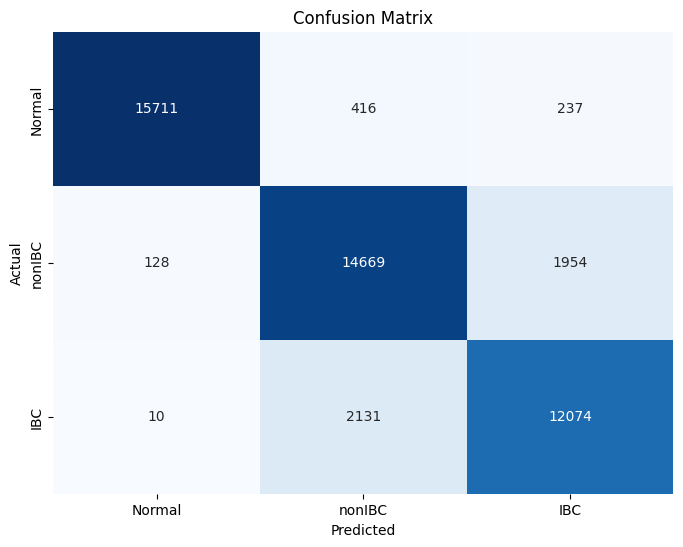


[[15711   416   237]
 [  128 14669  1954]
 [   10  2131 12074]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.9987 |  0.0   |   0.9987  |   0.9987  |
|   1   | 0.961  |  0.0   |   0.961   |   0.9611  |
|   2   | 0.9579 | 0.0001 |   0.9579  |   0.958   |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.9754  |   0.9913  | 0.9601 |    0.9955   | 0.9793 |  16364  |
|      1       |  0.8637  |   0.8521  | 0.8757 |    0.9167   | 0.9309 |  16751  |
|      2       |  0.8479  |   0.8464  | 0.8494 |    0.9338   | 0.9352 |  14215  |
|              |          |           |        |             |        |       

In [17]:
# SUQH Type
from metrics3 import report

y_pred = mclf.predict(np.array(X['test']))
y_prob = np.array(mclf.predict_proba(np.array(X['test'])))
y_true = np.array(Y['test'])
tasks = ['type', 'grade']
class_names = {
    'type': ['Normal', 'nonIBC', 'IBC'],
    'grade': ['Low', 'Median', 'High']
}

type_y_pred = y_pred[:, 0]
type_y_prob = y_prob[0, :]
type_y_true = y_true[:, 0]
type_cm = confusion_matrix(type_y_true, type_y_pred)
plot_confusion_matrix(type_cm, class_names['type'])
print(report(type_y_true, type_y_pred, type_y_prob, class_names['type']))




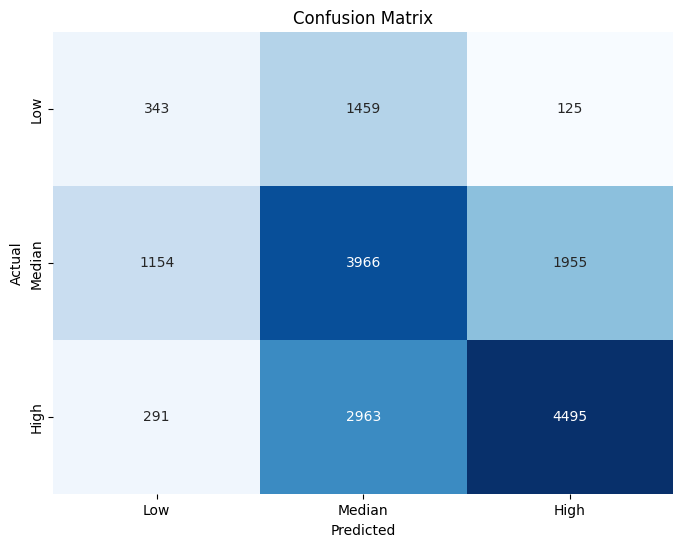


[[ 343 1459  125]
 [1154 3966 1955]
 [ 291 2963 4495]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.681  | 0.0004 |   0.6806  |   0.6813  |
|   1   | 0.5639 | 0.0003 |   0.5636  |   0.5641  |
|   2   | 0.7483 | 0.0002 |   0.7481  |   0.7486  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.1847  |   0.1918  | 0.178  |    0.9025   | 0.8941 |   1927  |
|      1       |  0.513   |   0.4728  | 0.5606 |    0.543    | 0.6282 |   7075  |
|      2       |  0.6276  |   0.6837  | 0.5801 |    0.7689   | 0.6802 |   7749  |
|              |          |           |        |             |        |         |
|   a

In [18]:
# SUQH nonIBC
tumor_idx = np.where(type_y_true == 1)[0]
grade_y_pred = y_pred[tumor_idx, 1]
grade_y_prob = y_prob[1, tumor_idx]
grade_y_true = y_true[tumor_idx, 1]
grade_cm = confusion_matrix(grade_y_true, grade_y_pred)
plot_confusion_matrix(grade_cm, class_names['grade'])
print(report(grade_y_true, grade_y_pred, grade_y_prob, class_names['grade']))

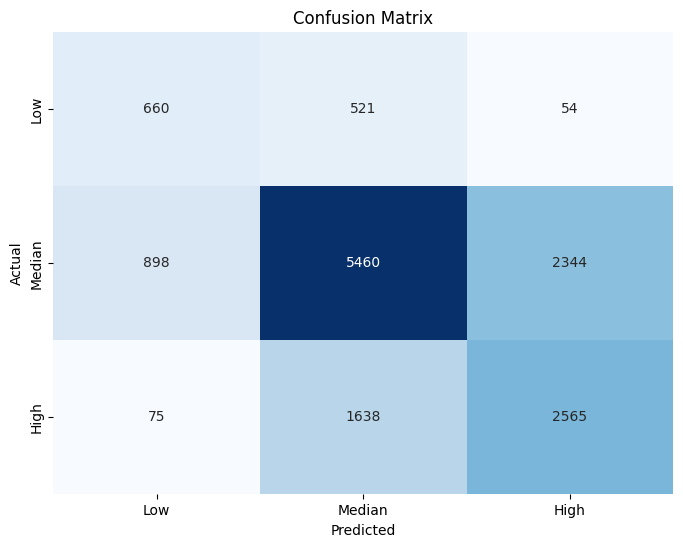


[[ 660  521   54]
 [ 898 5460 2344]
 [  75 1638 2565]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.8528 | 0.0003 |   0.8524  |   0.8531  |
|   1   | 0.6661 | 0.0003 |   0.6658  |   0.6663  |
|   2   | 0.7663 | 0.0003 |   0.766   |   0.7665  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.4603  |   0.4042  | 0.5344 |    0.925    | 0.9543 |   1235  |
|      1       |  0.6691  |   0.7166  | 0.6274 |    0.6084   | 0.5085 |   8702  |
|      2       |  0.5551  |   0.5168  | 0.5996 |    0.7587   | 0.8149 |   4278  |
|              |          |           |        |             |        |         |
|   a

In [19]:
# SUQH nonIBC
tumor_idx = np.where(type_y_true == 2)[0]
grade_y_pred = y_pred[tumor_idx, 1]
grade_y_prob = y_prob[1, tumor_idx]
grade_y_true = y_true[tumor_idx, 1]
grade_cm = confusion_matrix(grade_y_true, grade_y_pred)
plot_confusion_matrix(grade_cm, class_names['grade'])
print(report(grade_y_true, grade_y_pred, grade_y_prob, class_names['grade']))

In [25]:
def get_X_Y(data_root, save_root, phases=['test']):
    X={}
    Y={}
    for task in ['type', 'nonibc', 'ibc']:
        X[task] = {}
        Y[task] = {}
        for phase in phases:
            X[task][phase] = []
            Y[task][phase] = []

    for phase in phases:
        phase_root = data_root / phase
        tile_paths = list(phase_root.glob('**/*.jpg'))
        for path in tqdm(tile_paths, desc=f'Processing {phase}'):
            save_path = save_root / phase / path.parent.name /f'{path.stem}.npy' 
            if save_path.exists():
                feature = np.load(save_path)
            else:
                save_path.parent.mkdir(exist_ok=True, parents=True)
                im = Image.open(path)
                tensor = data_trans(im)
                batch = tensor.unsqueeze(0)
                batch = batch.to(device)
                feature = ibot_base_pancancer(batch).detach().cpu().numpy()
                feature = feature.flatten()
                np.save(save_path, feature)

            type, grade = get_type_grade(path)
            
            X['type'][phase].append(feature)
            Y['type'][phase].append(type)

            if type == 1:
                X['nonibc'][phase].append(feature)
                Y['nonibc'][phase].append(grade)
            elif type == 2:
                X['ibc'][phase].append(feature)
                Y['ibc'][phase].append(grade)
    return X, Y

In [26]:
qingdao_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/qingdao_test')
qingdao_save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/qingdao_test/test_swin_ibot_features')
qingdao_X, qingdao_Y = get_X_Y(qingdao_root, qingdao_save_root, phases=['test'])

Processing test: 100%|██████████| 5453/5453 [19:12<00:00,  4.73it/s]


In [27]:
tasks = ['type', 'nonibc', 'ibc']
class_names = {
    'type': ['Normal', 'nonIBC', 'IBC'],
    'nonibc': ['Low', 'Medium', 'High'],
    'ibc': ['Low', 'Medium', 'High'],
}

type


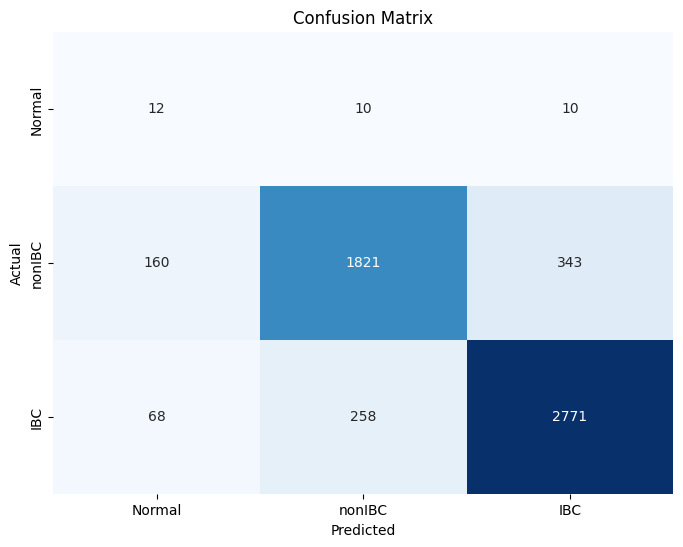


[[  12   10   10]
 [ 160 1821  343]
 [  68  258 2771]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.817  | 0.0023 |   0.8148  |   0.8193  |
|   1   | 0.925  | 0.0002 |   0.9248  |   0.9252  |
|   2   | 0.9401 | 0.0002 |   0.9399  |   0.9403  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.0882  |    0.05   | 0.375  |    0.9579   | 0.9962 |    32   |
|      1       |  0.8253  |   0.8717  | 0.7836 |    0.9143   | 0.8505 |   2324  |
|      2       |  0.8909  |   0.887   | 0.8947 |    0.8502   |  0.86  |   3097  |
|              |          |           |        |             |        |         |
|   a

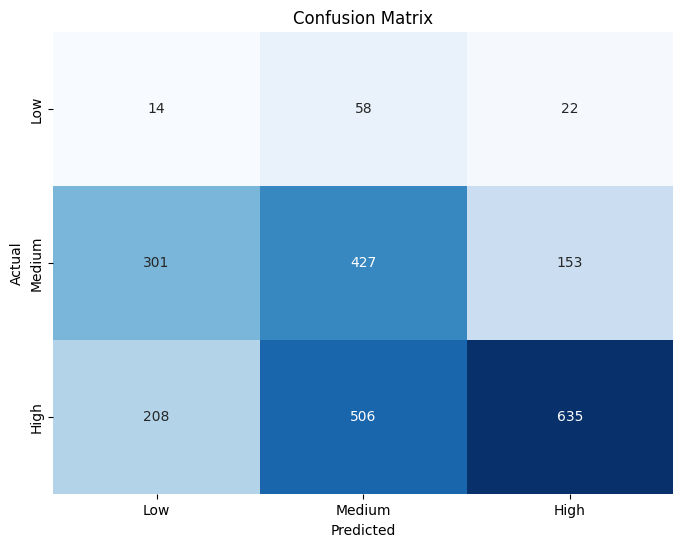


[[ 14  58  22]
 [301 427 153]
 [208 506 635]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.5811 | 0.0012 |   0.5798  |   0.5823  |
|   1   | 0.5711 | 0.0008 |   0.5703  |   0.5719  |
|   2   | 0.7067 | 0.0007 |   0.706   |   0.7073  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.0454  |   0.0268  | 0.1489 |    0.7717   | 0.9556 |    94   |
|      1       |  0.4562  |   0.4309  | 0.4847 |    0.6091   | 0.6594 |   881   |
|      2       |  0.5882  |   0.784   | 0.4707 |    0.8205   | 0.5284 |   1349  |
|              |          |           |        |             |        |         |
|   accuracy  

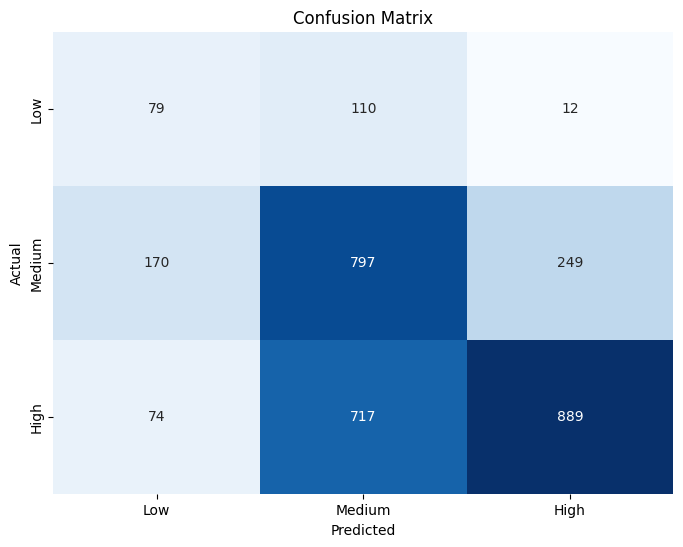


[[ 79 110  12]
 [170 797 249]
 [ 74 717 889]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.8516 | 0.0006 |   0.851   |   0.8522  |
|   1   | 0.6448 | 0.0007 |   0.6442  |   0.6455  |
|   2   | 0.7668 | 0.0005 |   0.7663  |   0.7673  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.3015  |   0.2446  | 0.393  |    0.9157   | 0.956  |   201   |
|      1       |  0.5613  |   0.4908  | 0.6554 |    0.5603   | 0.7155 |   1216  |
|      2       |  0.6283  |   0.773   | 0.5292 |    0.8158   | 0.5937 |   1680  |
|              |          |           |        |             |        |         |
|   accuracy  

In [28]:
X = qingdao_X
Y = qingdao_Y

for task in tasks:
    model = mclf
    preds = model.predict(np.array(X[task]['test']))
    probs = model.predict_proba(np.array(X[task]['test']))
    probs = np.array(probs)
    if task == 'type':
        preds = preds[:, 0]
        probs = probs[0, :]
    else:
        preds = preds[:, 1]
        probs = probs[1, :]
    labels = np.array(Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))

Processing test: 100%|██████████| 4545/4545 [17:49<00:00,  4.25it/s]


type


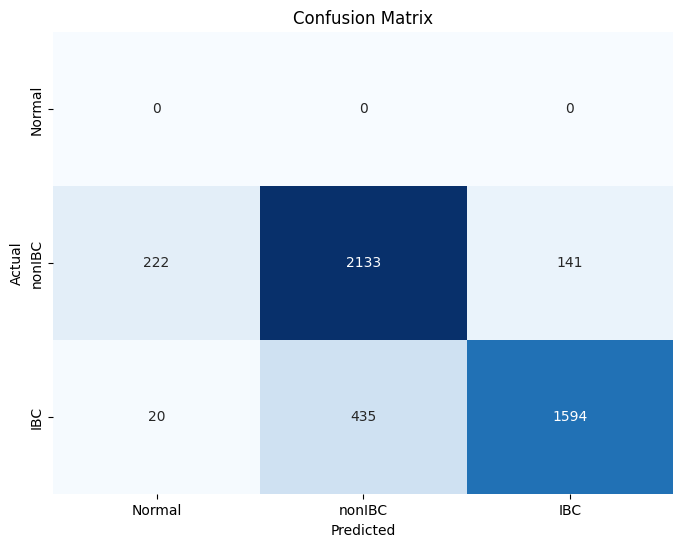

/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuxin/miniconda3/envs/histosslscaling/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arr


[[   0    0    0]
 [ 222 2133  141]
 [  20  435 1594]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   |  nan   |  nan   |    nan    |    nan    |
|   1   | 0.9005 | 0.0003 |   0.9003  |   0.9008  |
|   2   | 0.9424 | 0.0002 |   0.9422  |   0.9426  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |   0.0    |    0.0    |  0.0   |    0.9468   |  1.0   |    0    |
|      1       |  0.8424  |   0.8306  | 0.8546 |    0.7877   | 0.8164 |   2496  |
|      2       |  0.8425  |   0.9187  | 0.7779 |    0.9435   | 0.8381 |   2049  |
|              |          |           |        |             |        |         |
|   a

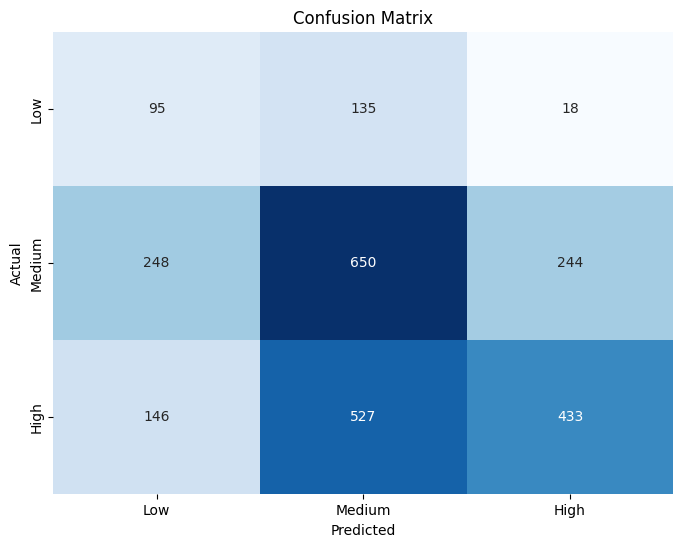


[[ 95 135  18]
 [248 650 244]
 [146 527 433]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.7327 | 0.0009 |   0.7318  |   0.7335  |
|   1   | 0.5487 | 0.0007 |   0.548   |   0.5494  |
|   2   | 0.6477 | 0.0007 |   0.6471  |   0.6484  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.2578  |   0.1943  | 0.3831 |    0.8247   | 0.9238 |   248   |
|      1       |  0.5297  |   0.4954  | 0.5692 |    0.5111   | 0.5845 |   1142  |
|      2       |  0.4808  |   0.623   | 0.3915 |    0.8115   | 0.6263 |   1106  |
|              |          |           |        |             |        |         |
|   accuracy  

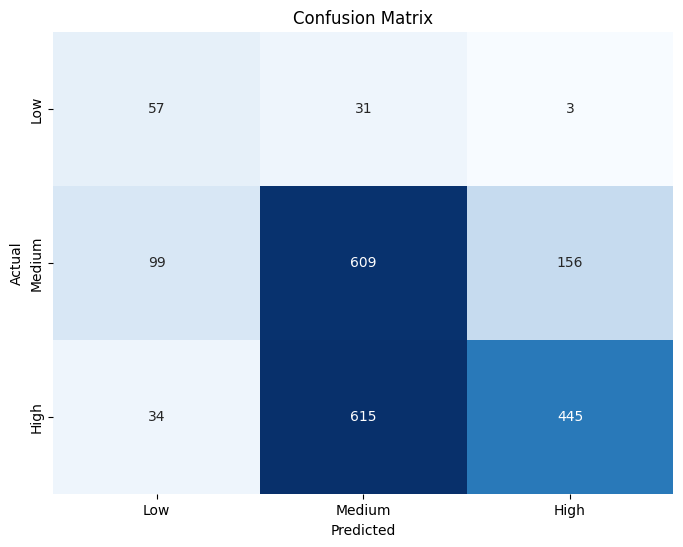


[[ 57  31   3]
 [ 99 609 156]
 [ 34 615 445]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.9119 | 0.0009 |   0.911   |   0.9127  |
|   1   | 0.6019 | 0.0007 |   0.6012  |   0.6027  |
|   2   | 0.6907 | 0.0007 |    0.69   |   0.6914  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.4057  |    0.3    | 0.6264 |    0.9321   | 0.9817 |    91   |
|      1       |  0.5748  |   0.4853  | 0.7049 |    0.4549   | 0.6788 |   864   |
|      2       |  0.5241  |   0.7368  | 0.4068 |    0.8335   | 0.5509 |   1094  |
|              |          |           |        |             |        |         |
|   accuracy  

In [29]:
shandaer_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/shandaer_test')
shandaer_save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/shandaer_test/test_swin_ibot_features')
X, Y = get_X_Y(shandaer_root, shandaer_save_root, phases=['test'])

for task in tasks:
    model = mclf
    preds = model.predict(np.array(X[task]['test']))
    probs = model.predict_proba(np.array(X[task]['test']))
    probs = np.array(probs)
    if task == 'type':
        preds = preds[:, 0]
        probs = probs[0, :]
    else:
        preds = preds[:, 1]
        probs = probs[1, :]
    labels = np.array(Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))

Processing test:   0%|          | 0/300 [00:00<?, ?it/s]

Processing test: 100%|██████████| 300/300 [00:06<00:00, 48.96it/s]


ibc


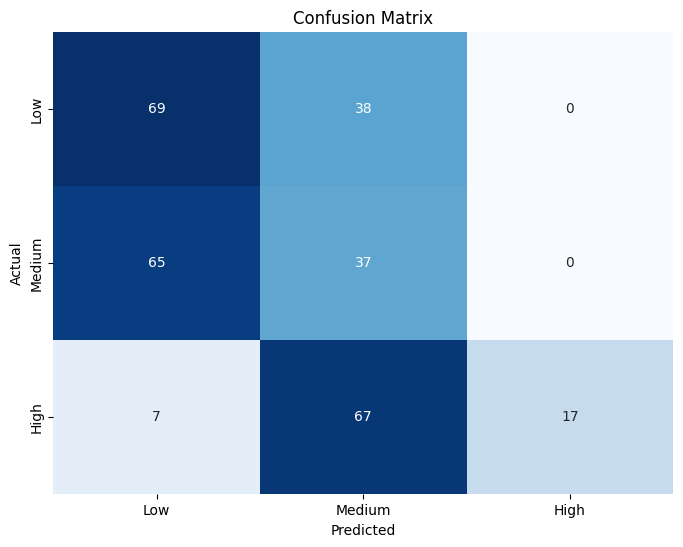


[[69 38  0]
 [65 37  0]
 [ 7 67 17]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.694  | 0.0019 |   0.6921  |   0.6959  |
|   1   | 0.418  | 0.0021 |   0.4159  |    0.42   |
|   2   | 0.7998 | 0.0017 |   0.7982  |   0.8015  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.5565  |   0.4894  | 0.6449 |    0.6269   | 0.761  |   107   |
|      1       |  0.3033  |   0.2606  | 0.3627 |    0.4697   | 0.5886 |   102   |
|      2       |  0.3148  |    1.0    | 0.1868 |     1.0     | 0.7385 |    91   |
|              |          |           |        |             |        |         |
|   accuracy   |       

In [44]:
apght_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/2017_Agios_Pavlos_patch')
apght_save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/2017_Agios_Pavlos_patch_pretrian_ssl_features')
X, Y = get_X_Y(apght_root, apght_root, phases=['test'])

for task in ['ibc']:
    model = mclf
    preds = model.predict(np.array(X[task]['test']))
    probs = model.predict_proba(np.array(X[task]['test']))
    probs = np.array(probs)
    if task == 'type':
        preds = preds[:, 0]
        probs = probs[0, :]
    else:
        preds = preds[:, 1]
        probs = probs[1, :]
    labels = np.array(Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))

In [49]:
def get_Bracs_X_Y(data_root, save_root, phases=['test']):
    data_root = pathlib.Path(data_root)
    save_root = pathlib.Path(save_root)
    X={}
    Y={}
    for task in ['type']:
        X[task] = {}
        Y[task] = {}
        for phase in phases:
            X[task][phase] = []
            Y[task][phase] = []

    for phase in phases:
        tile_paths = []
        for l in ['0_N', '5_DCIS', '6_IC']:
            tile_paths.extend(list((data_root).glob(f'*/{l}/*.png')))
        for path in tqdm(tile_paths, desc=f'Processing {phase}'):
            save_path = save_root / path.parent.name / path.name /f'{path.stem}.npy' 
            if save_path.exists():
                feature = np.load(save_path)
            else:
                save_path.parent.mkdir(exist_ok=True, parents=True)
                im = Image.open(path)
                tensor = data_trans(im)
                batch = tensor.unsqueeze(0)
                batch = batch.to(device)
                feature = ibot_base_pancancer(batch).detach().cpu().numpy()
                feature = feature.flatten()
                np.save(save_path, feature)

            if path.parent.name == '0_N':
                type = 0
            elif path.parent.name == '5_DCIS':
                type = 1
            elif path.parent.name == '6_IC':
                type = 2
            
            X['type'][phase].append(feature)
            Y['type'][phase].append(type)

    return X, Y

In [50]:
X,Y = get_Bracs_X_Y('/mnt/hd0/project_large_files/bcacad/patches/bracs_patch/latest_version_patch', '/mnt/hd0/project_large_files/bcacad/patches/bracs_patch/latest_version_patch_pre_ssl_features', phases=['test'])

Processing test: 100%|██████████| 10094/10094 [04:51<00:00, 34.62it/s]


type


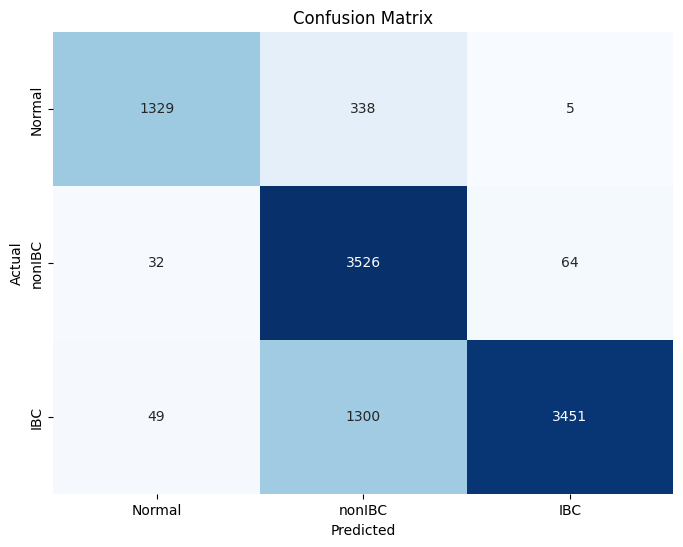


[[1329  338    5]
 [  32 3526   64]
 [  49 1300 3451]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.991  |  0.0   |   0.991   |   0.9911  |
|   1   | 0.9338 | 0.0001 |   0.9336  |   0.9339  |
|   2   | 0.9431 | 0.0001 |   0.943   |   0.9433  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.8624  |   0.9426  | 0.7949 |    0.9904   | 0.9605 |   1672  |
|      1       |  0.8026  |   0.6828  | 0.9735 |    0.7469   | 0.9805 |   3622  |
|      2       |  0.8296  |   0.9804  | 0.719  |    0.987    | 0.7948 |   4800  |
|              |          |           |        |             |        |         |
|   a

In [52]:
for task in ['type']:
    model = mclf
    preds = model.predict(np.array(X[task]['test']))
    probs = model.predict_proba(np.array(X[task]['test']))
    probs = np.array(probs)
    if task == 'type':
        preds = preds[:, 0]
        probs = probs[0, :]
    else:
        preds = preds[:, 1]
        probs = probs[1, :]
    labels = np.array(Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))

In [53]:
def get_BACH_X_Y(data_root, save_root, phases=['test']):
    data_root = pathlib.Path(data_root)
    save_root = pathlib.Path(save_root)
    X={}
    Y={}
    for task in ['type']:
        X[task] = {}
        Y[task] = {}
        for phase in phases:
            X[task][phase] = []
            Y[task][phase] = []

    for phase in phases:
        tile_paths = []
        for l in ['Normal', 'InSitu', 'Invasive']:
            tile_paths.extend(list((data_root/l).glob('**/*.tif')))
        for path in tqdm(tile_paths, desc=f'Processing {phase}'):
            save_path = save_root / path.parent.name / path.name /f'{path.stem}.npy' 
            if save_path.exists():
                feature = np.load(save_path)
            else:
                save_path.parent.mkdir(exist_ok=True, parents=True)
                im = Image.open(path)
                tensor = data_trans(im)
                batch = tensor.unsqueeze(0)
                batch = batch.to(device)
                feature = ibot_base_pancancer(batch).detach().cpu().numpy()
                feature = feature.flatten()
                np.save(save_path, feature)

            if path.parent.name == 'Normal':
                type = 0
            elif path.parent.name == 'InSitu':
                type = 1
            elif path.parent.name == 'Invasive':
                type = 2
            
            X['type'][phase].append(feature)
            Y['type'][phase].append(type)

    return X, Y

In [54]:
X,Y = get_BACH_X_Y('/mnt/hd0/project_large_files/bcacad/patches/bach_patch/Photos_patch_tif', '/mnt/hd0/project_large_files/bcacad/patches/bach_patch/Photos_patch_tif_pre_ssl_features', phases=['test'])

Processing test: 100%|██████████| 1200/1200 [00:30<00:00, 39.57it/s]


type


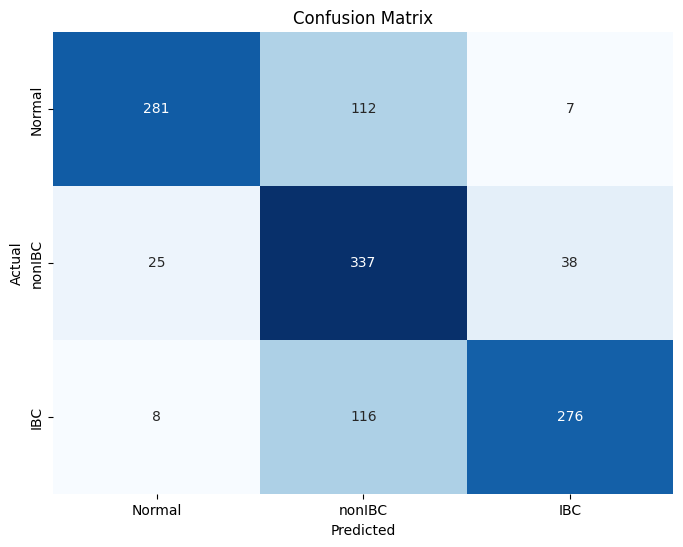


[[281 112   7]
 [ 25 337  38]
 [  8 116 276]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.9569 | 0.0003 |   0.9566  |   0.9573  |
|   1   | 0.8584 | 0.0007 |   0.8577  |   0.8591  |
|   2   | 0.9135 | 0.0006 |   0.9129  |   0.9142  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.7871  |   0.8949  | 0.7025 |    0.9588   | 0.8657 |   400   |
|      1       |  0.6984  |   0.5965  | 0.8425 |    0.715    | 0.9008 |   400   |
|      2       |  0.7656  |   0.8598  |  0.69  |    0.9438   | 0.8589 |   400   |
|              |          |           |        |             |        |         |
|   accuracy  

In [55]:
for task in ['type']:
    model = mclf
    preds = model.predict(np.array(X[task]['test']))
    probs = model.predict_proba(np.array(X[task]['test']))
    probs = np.array(probs)
    if task == 'type':
        preds = preds[:, 0]
        probs = probs[0, :]
    else:
        preds = preds[:, 1]
        probs = probs[1, :]
    labels = np.array(Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))

In [5]:
def get_BCNB_X_Y(data_root, save_root, phases=['test']):
    X={}
    Y={}
    for task in ['ibc']:
        X[task] = {}
        Y[task] = {}
        for phase in phases:
            X[task][phase] = []
            Y[task][phase] = []

    for phase in phases:
        phase_root = data_root
        tile_paths = list(phase_root.glob('**/*/*.jpg'))
        for path in tqdm(tile_paths, desc=f'Processing {phase}'):
            save_path = save_root / phase / path.parent.parent.name /f'{path.stem}.npy' 
            if save_path.exists():
                feature = np.load(save_path)
            else:
                save_path.parent.mkdir(exist_ok=True, parents=True)
                im = Image.open(path)
                tensor = data_trans(im)
                batch = tensor.unsqueeze(0)
                batch = batch.to(device)
                feature = ibot_base_pancancer(batch).detach().cpu().numpy()
                feature = feature.flatten()
                np.save(save_path, feature)

            grade = int(path.parent.parent.name.split('-')[-1])-1
            

            X['ibc'][phase].append(feature)
            Y['ibc'][phase].append(grade)
    return X, Y

In [16]:
bcnb_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/bcnb/patches_test_10x')
bcnb_save_root = pathlib.Path('/mnt/hd0/project_large_files/bcacad/patches/bcnb/patches_test_10x_pre_ssl_features')
X, Y = get_BCNB_X_Y(bcnb_root, bcnb_save_root, phases=['test'])

Processing test: 100%|██████████| 9686/9686 [00:03<00:00, 2807.31it/s]


In [7]:
Y['ibc']['test'] = np.array(Y['ibc']['test'])
np.unique(Y['ibc']['test'], return_counts=True)

(array([0, 1, 2]), array([ 355, 5704, 3627]))

ibc


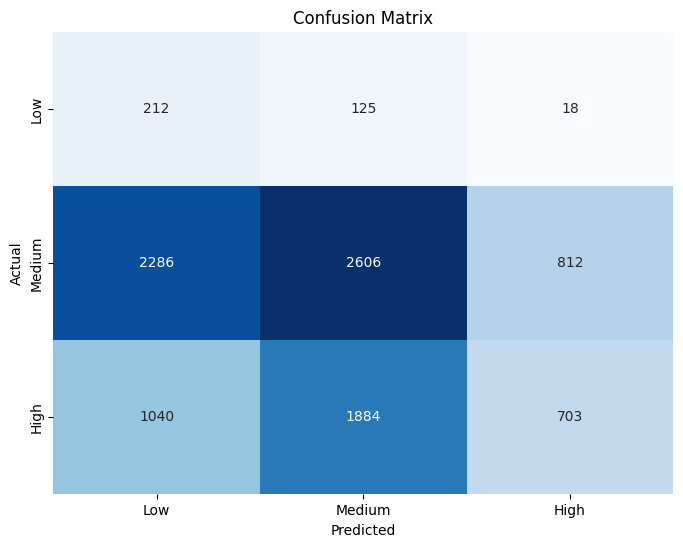


[[ 212  125   18]
 [2286 2606  812]
 [1040 1884  703]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.6797 | 0.0008 |   0.6789  |   0.6805  |
|   1   | 0.4662 | 0.0004 |   0.4659  |   0.4666  |
|   2   | 0.5657 | 0.0004 |   0.5653  |   0.5661  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.1089  |   0.0599  | 0.5972 |    0.6436   | 0.9767 |   355   |
|      1       |  0.5051  |   0.5647  | 0.4569 |    0.4955   | 0.3891 |   5704  |
|      2       |  0.2725  |   0.4586  | 0.1938 |    0.863    | 0.6414 |   3627  |
|              |          |           |        |             |        |         |
|   a

In [20]:
from metrics3 import report
for task in ['ibc']:
    model = mclf
    preds = model.predict(np.array(X[task]['test']))
    probs = model.predict_proba(np.array(X[task]['test']))
    probs = np.array(probs)
    if task == 'type':
        preds = preds[:, 0]
        probs = probs[0, :]
    else:
        preds = preds[:, 1]
        probs = probs[1, :]
    labels = np.array(Y[task]['test'])
    print(task)
    cm = confusion_matrix(labels, preds)
    plot_confusion_matrix(cm, class_names[task])
    print(report(labels, preds, probs, class_names[task]))

In [21]:
a= report(labels, preds, probs, class_names[task])


[[ 212  125   18]
 [2286 2606  812]
 [1040 1884  703]]

+-------+--------+--------+-----------+-----------+
| class |  auc   | 95%ci  | auc_lower | auc_upper |
+-------+--------+--------+-----------+-----------+
|   0   | 0.6797 | 0.0008 |   0.6789  |   0.6805  |
|   1   | 0.4662 | 0.0004 |   0.4659  |   0.4666  |
|   2   | 0.5657 | 0.0004 |   0.5653  |   0.5661  |
+-------+--------+--------+-----------+-----------+
+--------------+----------+-----------+--------+-------------+--------+---------+
|    class     | f1-score | precision | recall | specificity |  NPV   | support |
+--------------+----------+-----------+--------+-------------+--------+---------+
|      0       |  0.1089  |   0.0599  | 0.5972 |    0.6436   | 0.9767 |   355   |
|      1       |  0.5051  |   0.5647  | 0.4569 |    0.4955   | 0.3891 |   5704  |
|      2       |  0.2725  |   0.4586  | 0.1938 |    0.863    | 0.6414 |   3627  |
|              |          |           |        |             |        |         |
|   a

In [23]:
a['0']['auc']

0.6797